# Tutorial for spatial mapping using _Tangram_
- by Ziqing Lu <luz21@gene.com> and Tommaso Biancalani <biancalt@gene.com>.
- Last update: August 16th 2021

### What is _Tangram_?
_Tangram_ is a method for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. _Tangram_ takes as input a single-cell dataset and a spatial dataset, collected from the same anatomical region/tissue type. Via integration,  _Tangram_ <u>creates new spatial data by aligning the scRNAseq profiles in space</u>. This allows to project every annotation in the scRNAseq (_e.g._ cell types, program usage) on space.


### What do I use _Tangram_ for?
The most common application of _Tangram_ is to resolve cell types in space. Another usage is to correct gene expression from spatial data: as scRNA-seq data are less prone to dropout than (_e.g._) Visium or Slide-seq, the "new" spatial data generated by _Tangram_ resolve many more genes. As a result, we can visualize program usage in space, which can be used for ligand-receptor pair discovery or, more generally, cell-cell communication mechanisms. If cell segmentation is available, _Tangram_ can be also used for deconvolution of spatial data. If your single cell are multimodal, _Tangram_ can be used to spatially resolve other modalities, such as chromatin accessibility.

***
### Frequently Asked Questions about _Tangram_
- A more updated version can be found [FINISH]().

##### How is _Tangram_ different, than all the other deconvolution/mapping method?
- Validation. Most methods "validate" mappings by looking at known patterns or proportion of cell types. These are good sanity checks, but are hardly useful when mapping is used for discovery. In _Tangram_, mappings are validated by inspective the predictions of holdout genes (test transcriptome).


##### My scRNAseq/spatial data come from different samples. Can I still use _Tangram_?
- Yes. There is a clever variation invented by [Sten Linnarsson](http://linnarssonlab.org/), which consists of mapping _average_ cells of a certain cell type, rather than single cells. This method is much faster, and  smooths out variation in biological signal from different samples via averaging. However, it requires annotated scRNA-seq, sacrifices resolving biological variability at single-cell level. To map this way, pass `method=cluster` [FINISH](...FINISH...)


##### Does _Tangram_ only work on mouse brain data?
- **No.** The original manuscript focused on mouse brain data b/c was funded by BICCN. We subsequently used _Tangram_ for mapping lung, kidney and cancer tissue. If mapping doesn't work for your case, that is hardly due to the complexity of the tissue.


##### Why doesn't _Tangram_ have hypotheses on the underlying model?
- Most models used in biology are probabilistic: they assume that data are generated according to a certain probability distribution, hence the hypothesis. But _Tangram_ doesn't work that way: the hypothesis is that scRNA-seq and spatial data are generated with the same process (_i.e._ same biology) regardless of the process.


##### Where do I learn more about _Tangram_?
- Check out our [documentation](https://tangram-sc.readthedocs.io/) for learning more about the method, or our [GitHub repo](https://github.com/broadinstitute/Tangram) for the latest version of the code. Tangram has been released in <cite data-cite="tangram">Biancalani, Scalia et al. Nature Methods (2021)</cite>.

***
## Setting up
_Tangram_ is based on pytorch, scanpy and (optionally but highly-recommended) squidpy - this tutorial is designed to work with squidy.  You can also check [FINISH](another tutorial), prior to integration with squidpy. 

- To run the notebook locally, create a conda environment as `conda env create -f tangram_environment.yml` using our [YAML file](https://github.com/theislab/squidpy_notebooks/blob/master/envs/tangram_environment.yml). 
- This notebook is based on squidpy v1.1.0.

In [ ]:
!git clone https://github.com/broadinstitute/Tangram

Cloning into 'Tangram'...
remote: Enumerating objects: 1396, done.
remote: Counting objects: 100% (624/624), done.
remote: Compressing objects: 100% (438/438), done.
remote: Total 1396 (delta 359), reused 401 (delta 161), pack-reused 772
Receiving objects: 100% (1396/1396), 134.02 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (793/793), done.


In [2]:
import os
import sys 

In [1]:
#!pip3 install scanpy

#!pip3 install tangram-sc
#!pip3 install squidpy
import scanpy as sc
#import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg


In [4]:
sc.logging.print_header()
#print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.4.2 scikit-learn==1.2.2 statsmodels==0.13.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading datasets
Load public data available in Squidpy, from mouse brain cortex. Single cell data are stored in `adata_sc`. Spatial data, in `adata_st`.

In [ ]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [ ]:
adata_sc = sc.read_mtx('/content/drive/MyDrive/SpatialModelProject/data/scdata/CID44971/count_matrix_sparse.mtx').T
import pandas as pd 

adata_sc.var_names = pd.read_table('/content/drive/MyDrive/SpatialModelProject/data/scdata/CID44971/count_matrix_genes.tsv',header=None)[0]
adata_sc.obs_names = pd.read_table('/content/drive/MyDrive/SpatialModelProject/data/scdata/CID44971/count_matrix_barcodes.tsv',header=None)[0]

# filter only three cell types
meta = pd.read_csv('/content/drive/MyDrive/SpatialModelProject/data/scdata/CID44971/metadata_cut.csv', index_col=0)
#meta = meta[(meta['celltype_major']=='Normal Epithelial')| (meta['celltype_major']=='Cancer Epithelial') | (meta['celltype_major']=='T-cells')]
#meta.to_csv('scdata/CID44971/metadata_cut.csv')

adata_sc = adata_sc[meta.index,:]

adata_sc.obs = meta


#st_adata = sc.read(out1, backup_url=url1)
adata_st = sc.read_csv('/content/drive/MyDrive/SpatialModelProject/data/simu_data/simu_3/counts.st_synth.csv')

In [ ]:
adata_sc

AnnData object with n_obs × n_vars = 5995 × 29733
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'

We subset the crop of the mouse brain to only contain clusters of the brain cortex.  The pre-processed single cell dataset was taken from <cite data-cite="tasic2018shared">Tasic et al. (2018)</cite> and pre-processed with standard scanpy functions. 

Let's visualize both spatial and single-cell datasets.

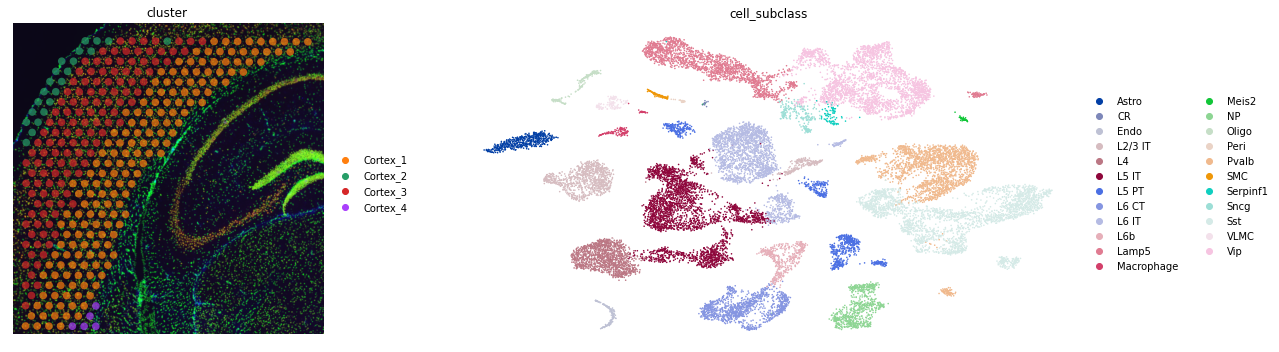

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

***
## The _Tangram_ trick: scRNA-seq are the new spatial data

_Tangram_ learns a spatial alignment of the single cell data by looking at a subset of genes, specified by the user, called the training genes. Training genes need to bear interesting signal and to be measured with high quality. Typically, we choose the training genes are 100-1000 differentially expressedx genes, stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.

_Tangram_ fits the scRNA-seq profiles on space using a custom loss function based on cosine similarity. The method is summarized in the sketch below:

![title](figures/how_tangram_works.png)

### Pre-processing

For this case, we use 1401 marker genes as training genes.

In [ ]:
sc.tl.rank_genes_groups(adata_sc, groupby="celltype_major", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

299

We prepares the data using `pp_adatas`, which does the following:
- Takes a list of genes from user via the `genes` argument. These genes are used as training genes.
- Annotates training genes under the `training_genes` field, in `uns` dictionary, of each AnnData. 
- Ensure consistent gene order in the datasets (_Tangram_ requires that the the $j$-th column in each matrix correspond to the same gene).
- If the counts for a gene are all zeros in one of the datasets, the gene is removed from the training genes.
- If a gene is not present in both datasets, the gene is removed from the training genes.

In [ ]:
pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:273 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5895 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Two datasets contain 1280 training genes of the 1401 originally provided, as some training genes have been removed.

### Find alignment

To find the optimal spatial alignment for scRNA-seq profiles, we use the `map_cells_to_space` function:
- The function maps iteratively as specified by `num_epochs`. We typically interrupt mapping  after the score plateaus. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data on the training genes.
- The default mapping mode is `mode='cells'`, which is recommended to run on a GPU. 
- Alternatively, one can specify `mode='clusters'` which averages the single cells beloning to the same cluster (pass annotations via  `cluster_label`). This is faster, and is our chioce when scRNAseq and spatial data come from different specimens.
- If you wish to run Tangram with a GPU, set `device=cuda:0` otherwise use the set `device=cpu`. 
- `density_prior` specifies the cell density within each spatial voxel. Use `uniform` if the spatial voxels are at single cell resolution (_ie_ MERFISH). The default value, `rna_count_based`, assumes that cell density is proportional to the number of RNA molecules.

In [ ]:
ad_map = map_cells_to_space(adata_sc, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
#     device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 273 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.603, KL reg: 0.074
Score: 0.905, KL reg: 0.002
Score: 0.912, KL reg: 0.002
Score: 0.913, KL reg: 0.002
Score: 0.914, KL reg: 0.002


INFO:root:Saving results..


The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
- The cell-by-spot matrix `X` contains the probability of cell `i` to be in spot `j`.
- The `obs` dataframe contains the metadata of the single cells.
- The `var` dataframe contains the metadata of the spatial data.
- The `uns` dictionary contains a dataframe with various information about the training genes (saved as `train_genes_df`).

### Cell type maps

To visualize cell types in space, we invoke `project_cell_annotation` to transfer the `annotation` from the mapping to space. We can then call `plot_cell_annotation` to visualize it. You can set the `perc` argument to set the range to the colormap, which would help remove outliers.

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


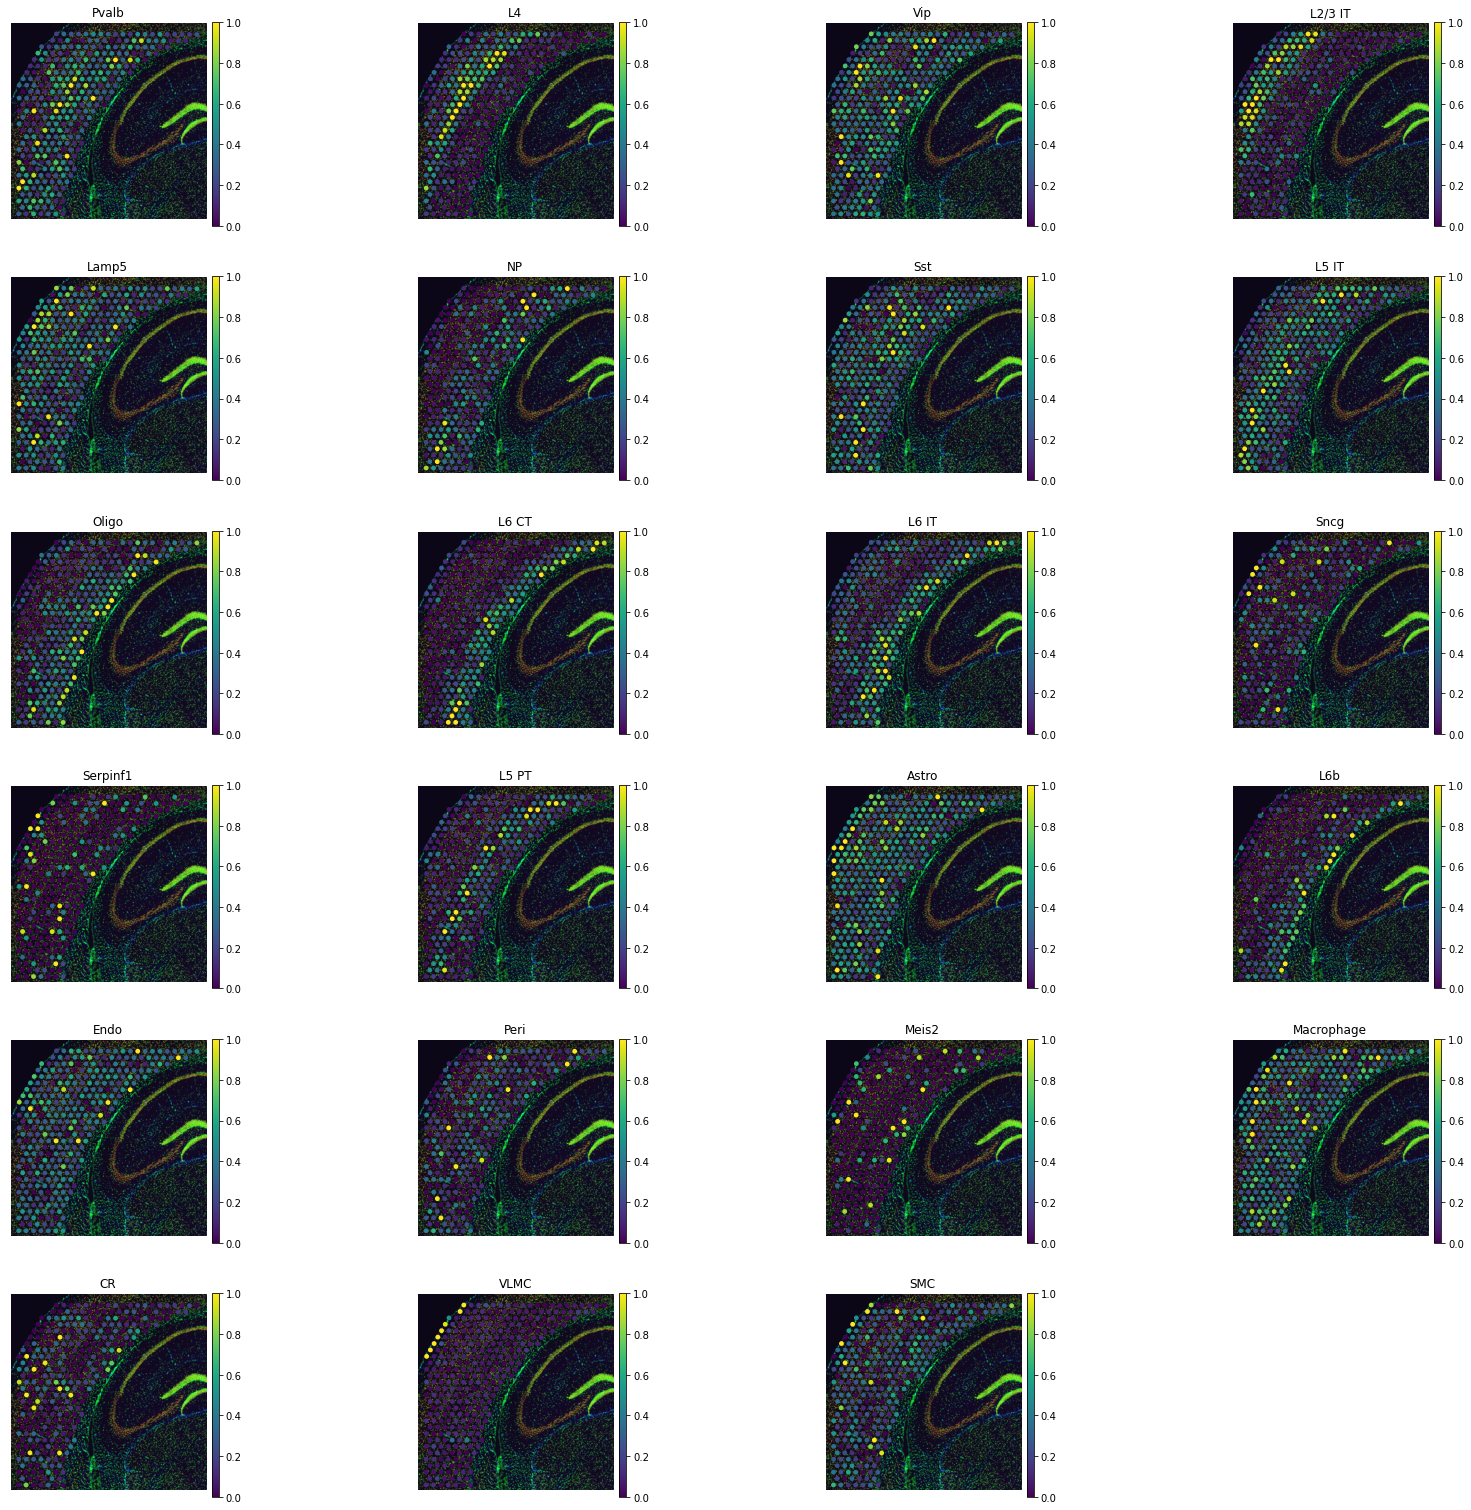

In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg.plot_cell_annotation(adata_st, annotation_list, perc=0.02)

The first way to get a sense if mapping was successful is to look for known cell type patterns. To get a deeper sense, we can use the helper `plot_training_scores` which gives us four panels:

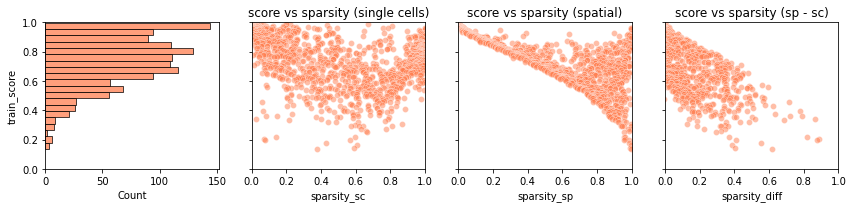

In [ ]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

- The first panel is a histogram of the simlarity scores for each training gene.
- In the second panel, each dot is a training gene and we can observe the training score (y-axis) and the sparsity in the scRNA-seq data (x-axis) of each gene. 
- The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
- In the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores. These information are stored in the dataframe `.uns['train_genes_df']`; this is the dataframe used to build the four plots above.

In [ ]:
ad_map.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
ppia         0.998169     0.000092     0.000000      -0.000092
ubb          0.997368     0.000092     0.000000      -0.000092
atp1b1       0.997035     0.014334     0.000000      -0.014334
tmsb4x       0.996994     0.002811     0.000000      -0.002811
ckb          0.996371     0.002765     0.000000      -0.002765
...               ...          ...          ...            ...
gabrb2       0.195180     0.078951     0.956790       0.877839
cdyl2        0.179485     0.425911     0.981481       0.555570
cntnap5c     0.160269     0.608241     0.993827       0.385586
dlx1as       0.144146     0.587777     0.990741       0.402964
kcnh6        0.136067     0.379131     0.996914       0.617783

[1280 rows x 4 columns]

### New spatial data via aligned single cells

If the mapping mode is `'cells'`, we can now generate the "new spatial data" using the mapped single cell: this is done via `project_genes`. The function accepts as input a mapping (`adata_map`) and corresponding single cell data (`adata_sc`). The result is a voxel-by-gene `AnnData`, formally similar to `adata_st`, but containing gene expression from the mapped single cell data rather than Visium. For downstream analysis, we always replace `adata_st` with the corresponding `ad_ge`.

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'training_genes', 'overlap_genes'

Let's choose a few training genes mapped with low score, to try to understand why.

In [ ]:
genes = ['rragb', 'trim17', 'eno1b']
ad_map.uns['train_genes_df'].loc[genes]

train_score  sparsity_sc  sparsity_sp  sparsity_diff
rragb      0.358362     0.079919     0.867284       0.787365
trim17     0.203126     0.069641     0.959877       0.890236
eno1b      0.341443     0.022492     0.885802       0.863311

To visualize gene patterns, we use the helper `plot_genes`. This function accepts two voxel-by-gene `AnnData`: the actual spatial data  (`adata_measured`), and a Tangram spatial prediction (`adata_predicted`). The function returns gene expression maps from the two spatial `AnnData` on the genes `genes`.


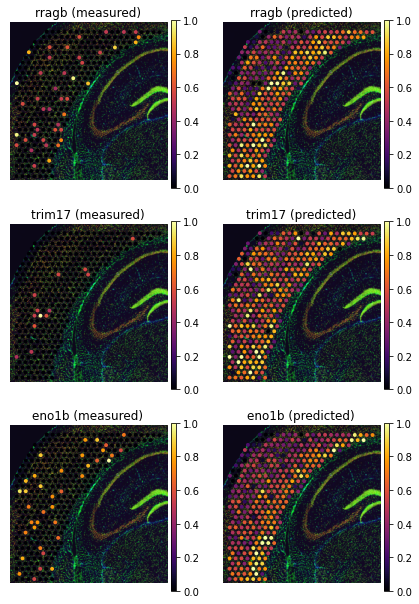

In [ ]:
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

The above pictures explain the low training scores. Some genes are detected with very different levels of sparsity - typically they are much more sparse in the scRNAseq than in the spatial data. This is due to the fact that technologies like Visium are more prone to technical dropouts. Therefore, _Tangram_ cannot find a good spatial alignment for these genes as the baseline signal is missing. However, so long as _most_ training genes are measured with high quality, we can trust mapping and use _Tangram_ prediction to correct gene expression. This is an imputation method which relies on entirely different premises than those in probabilistic models. 

Another application is found by inspecting genes that are not detected in the spatial data, but are detected in the single cell data. They are removed before training with `pp_adatas` function, but _Tangram_ can predict their expression.

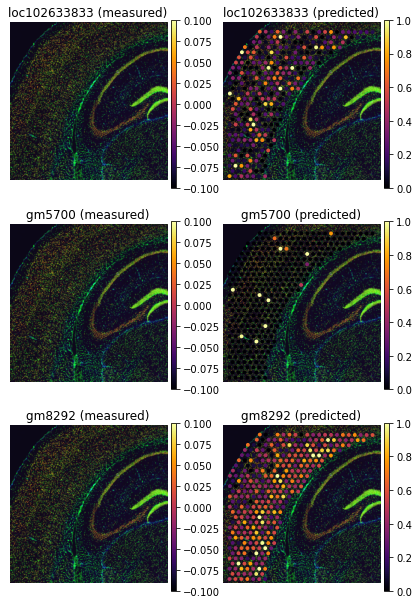

In [ ]:
genes=['loc102633833', 'gm5700', 'gm8292']
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

- So far, we only inspected genes used to align the data (training genes), but the mapped single cell data, `ad_ge` contains the whole transcriptome. That includes more than 35k test genes.

In [ ]:
(ad_ge.var.is_training == False).sum()

35546

We can use `plot_genes` to inspect gene expression of test genes as well. Inspecting the test transcriptome is an essential to validate mapping. At the same time, we need to be careful that some prediction might disagree with spatial data because of the technical droputs.

It is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial AnnDatas (ie voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the boolean field `is_training`. If we also pass single cell AnnData to `compare_spatial_geneexp` function like below, a dataframe with additional sparsity columns - sparsity_sc (single cell data sparsity) and sparsity_diff (spatial data sparsity - single cell data sparsity) will return. This is required if we want to call `plot_test_scores` function later with the returned datafrme from `compare_spatial_geneexp` function.

In [ ]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
snap25   0.998235        False     0.000000     0.014610      -0.014610
gapdh    0.998206        False     0.000000     0.000968      -0.000968
ppia     0.998169         True     0.000000     0.000092      -0.000092
calm1    0.997957        False     0.000000     0.000369      -0.000369
calm2    0.997747        False     0.000000     0.001751      -0.001751
...           ...          ...          ...          ...            ...
prr32    0.000011        False     0.993827     0.999263      -0.005435
gm15133  0.000010        False     0.996914     0.999170      -0.002257
clec12a  0.000008        False     0.996914     0.998848      -0.001934
kcnk5    0.000008        False     0.996914     0.998894      -0.001980
cckar    0.000005        False     0.996914     0.999309      -0.002395

[14785 rows x 5 columns]

The prediction on test genes can be graphically visualized using `plot_auc`:

<Figure size 432x288 with 0 Axes>

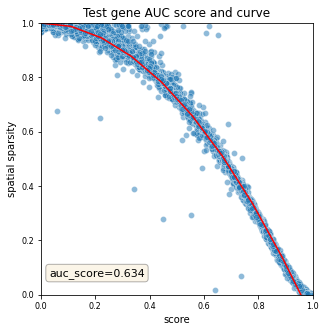

In [ ]:
# sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);  # for legacy
tg.plot_auc(df_all_genes);

**This above figure is the most important validation plot in _Tangram_.** Each dot represents a gene; the x-axis indicates the score, and the y-axis the sparsity of that gene in the spatial data.  Unsurprisingly, the genes predicted with low score represents very sparse genes in the spatial data, suggesting that the _Tangram_ predictions correct expression in those genes. Note that curve observed above is typical of _Tangram_ mappings: the area under that curve is the most reliable metric we use to evaluate mapping.

Let's inspect a few predictions. Some of these genes are biologically sparse, but well predicted:

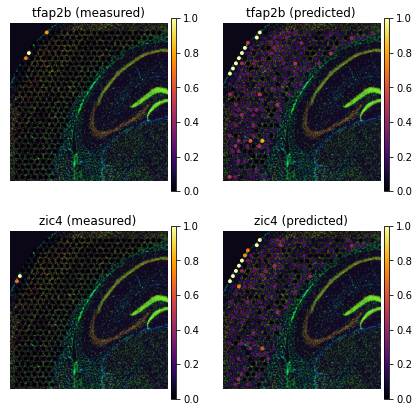

In [ ]:
genes=['tfap2b', 'zic4']
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

Some non-sparse genes present petterns, that _Tangram_ accentuates:

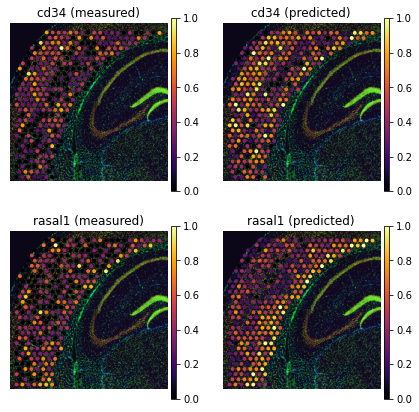

In [ ]:
genes = ['cd34', 'rasal1']
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

Finally, some unannotated genes have unknown function. These genes are often hardly detected in spatial data but _Tangram_ provides prediction:

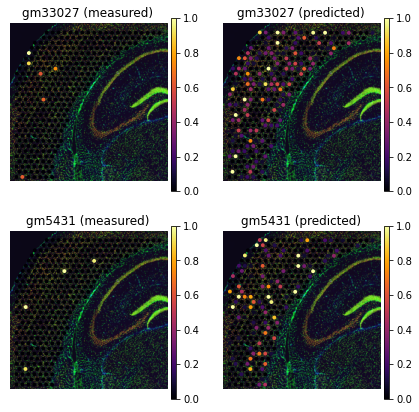

In [ ]:
genes = ['gm33027', 'gm5431']
tg.plot_genes(genes[:5], adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

***
## Deconvolution

For untargeted spatial technologies, like Visium and Slide-seq, a spatial voxel may contain more than one cells. In these cases, it might be useful to disentangle gene expression into single cells - a process called deconvolution. Deconvolution is a requested feature, and also hard to obtain accurately with computational methods. If your goal is to study co-localization of cell types, we recommend you work with the spatial cell type maps instead. If your aim is discovery of cell-cell communication mechanisms, we suggest you compute gene programs, then use `project_cell_annotations` to spatially visualize program usage. To proceed with deconvolution anyways, see below.

In order to deconvolve cells, _Tangram_ needs to know how many cells are present in each voxel. This is achieved by segmenting the cells on the corresponding histology, which squidpy makes possible with two lines of code:
- `squidpy.im.process` applies smoothing as a pre-processing step.
- `squidpy.im.segment` computes segmentation masks with watershed algorithm.

Note that some technologies, like Slide-seq, currently do not allow staining the same slide of tissue on which genes are profiled. For these data, you can still attempt a deconvolution by estimating cell density in a rough way - often we just pass a uniform prior. Finally, note that deconvolutions are hard to validate, as we do not have ground truth spatially-resolved single cells.

In [ ]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

Let's visualize the segmentation results for an inset

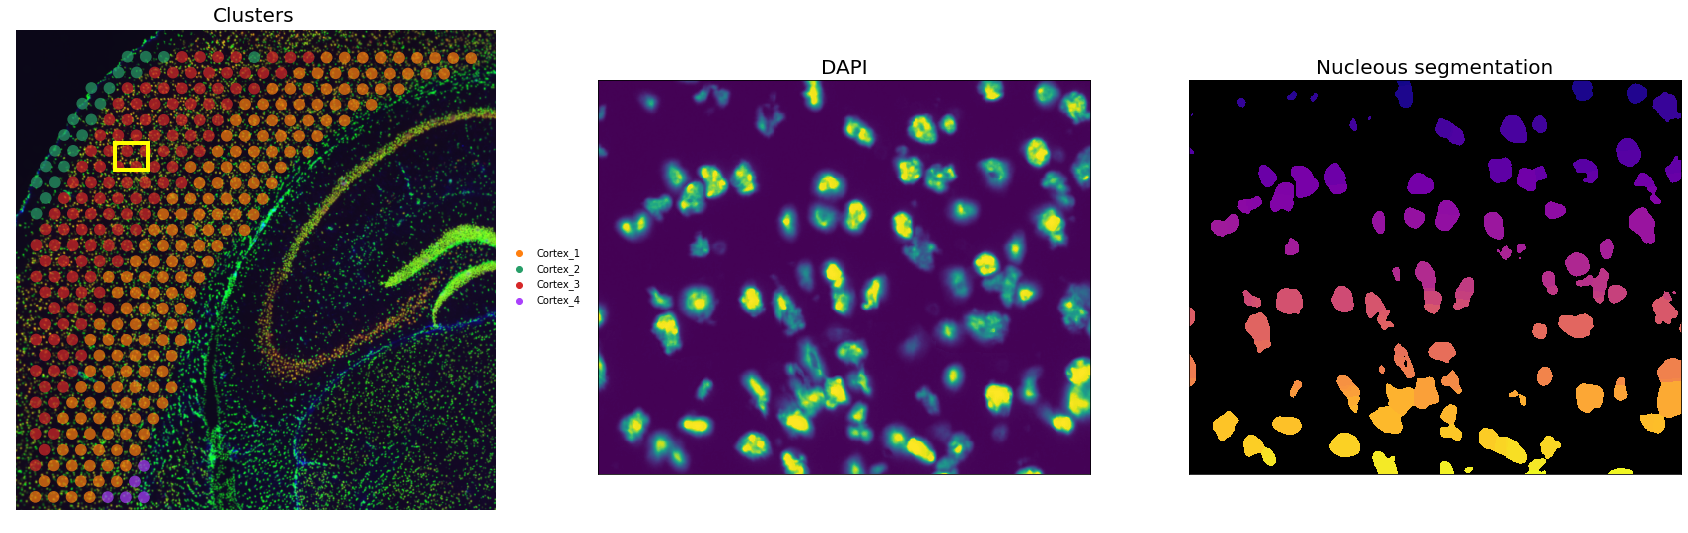

In [ ]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

Comparison between DAPI and mask confirms the quality of the segmentation. We then need to extract some image features useful for the deconvolution task downstream. Specifically:
- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.

In [ ]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

We can visualize the total number of objects under each spot with scanpy.

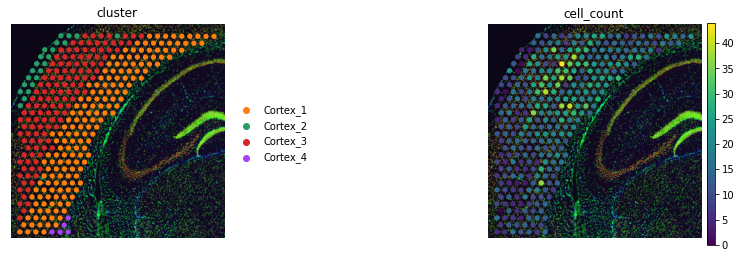

In [ ]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

### Deconvolution via alignment

The rationale for deconvolving with Tangram, is to constrain the number of mapped single cell profiles. This is different that most deconvolution method. Specifically, we set them equal to the number of segmented cells in the histology, in the following way:
- We pass `mode='constrained'`. This adds a filter term to the loss function, and a boolean regularizer.
- We set `target_count` equal to the total number of segmented cells. _Tangram_ will look for the best `target_count` cells to align in space.
- We pass a `density_prior`, containing the fraction of cells per voxel. 

In [ ]:
ad_map = map_cells_to_space(
    adata_sc,
    adata_st,
    #mode="constrained",
    #target_count=adata_st.obs.cell_count.sum(),
    #density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
#     device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 273 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.603, KL reg: 0.074
Score: 0.905, KL reg: 0.002
Score: 0.912, KL reg: 0.002
Score: 0.913, KL reg: 0.002
Score: 0.914, KL reg: 0.002
Score: 0.914, KL reg: 0.002
Score: 0.914, KL reg: 0.002
Score: 0.914, KL reg: 0.002
Score: 0.914, KL reg: 0.002
Score: 0.914, KL reg: 0.002


INFO:root:Saving results..


In the same way as before, we can plot cell type maps:

In [ ]:
ad_map

AnnData object with n_obs × n_vars = 5995 × 2551
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'
    var: 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [ ]:
from Tangram.tangram import project_cell_annotations

In [ ]:
project_cell_annotations(ad_map, adata_st, annotation="celltype_major")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [ ]:
adata_st.obsm['tangram_ct_pred']

T-cells  Cancer Epithelial  Normal Epithelial
Spotx1     0.857362           0.000247           0.186222
Spotx2     1.010377           0.041021           0.000083
Spotx3     0.821621           0.455445           0.000071
Spotx4     1.166297           1.112176           0.000068
Spotx5     3.300454           0.019408           0.239341
...             ...                ...                ...
Spotx2547  1.133650           0.276063           0.171384
Spotx2548  0.699285           0.094009           0.505147
Spotx2549  1.076182           0.206611           0.262644
Spotx2550  3.222297           0.377379           0.000047
Spotx2551  1.652327           0.000126           0.000076

[2551 rows x 3 columns]

In [ ]:
member = pd.read_csv('/content/drive/MyDrive/SpatialModelProject/data/simu_data/simu_3/members.st_synth.csv',index_col=0)
proportions = pd.read_csv('/content/drive/MyDrive/SpatialModelProject/data/simu_data/simu_3/proportions.st_synth.csv',index_col=0)

Text(0, 0.5, 'Predicted truth proportions')

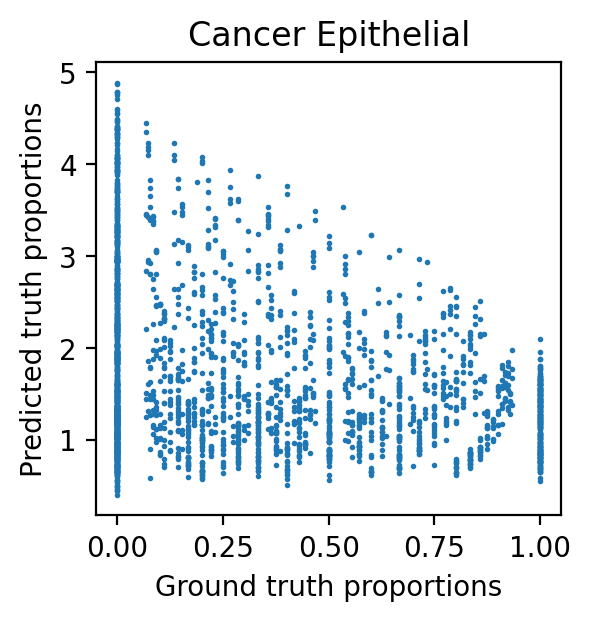

In [ ]:
idx = 0
plt.figure(dpi=200,figsize=(3,3))
plt.scatter(proportions.iloc[:,idx],np.array(adata_st.obsm['tangram_ct_pred'].iloc[:,idx]),s=1)
plt.title(proportions.columns[idx])
plt.xlabel('Ground truth proportions')
plt.ylabel('Predicted truth proportions')

In [ ]:
from scipy.stats import pearsonr
corr_map_qcm = np.zeros([3,3])
corr_map_genesig = np.zeros([3,3])
for i in range(3):
    for j in range(3):
        corr_map_qcm[i,j], _ = pearsonr(adata_st.obsm['tangram_ct_pred'].iloc[:,i], proportions.iloc[:,j])
        #corr_map_genesig[i,j], _ = pearsonr(gene_sig_exp_m.iloc[:,i], proportions.iloc[:,j])
        
        

In [ ]:
import seaborn as sns
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.figure(dpi=100,figsize=(2,2))
ax = sns.heatmap(corr_map_qcm, annot=True,cmap='RdBu_r',vmax=1,vmin=-1)
#plt.imshow(corr_map_qcm,vmin=-1,vmax=1,cmap='RdBu_r')
#plt.set_xtickslabel(['1','2','3'])
plt.xticks([0,1,2],labels=proportions.columns,rotation=90)
plt.yticks([0,1,2],labels=proportions.columns,rotation=0)
plt.xlabel('predicted proportions from destVI')
plt.ylabel('proportions')


In [ ]:
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))


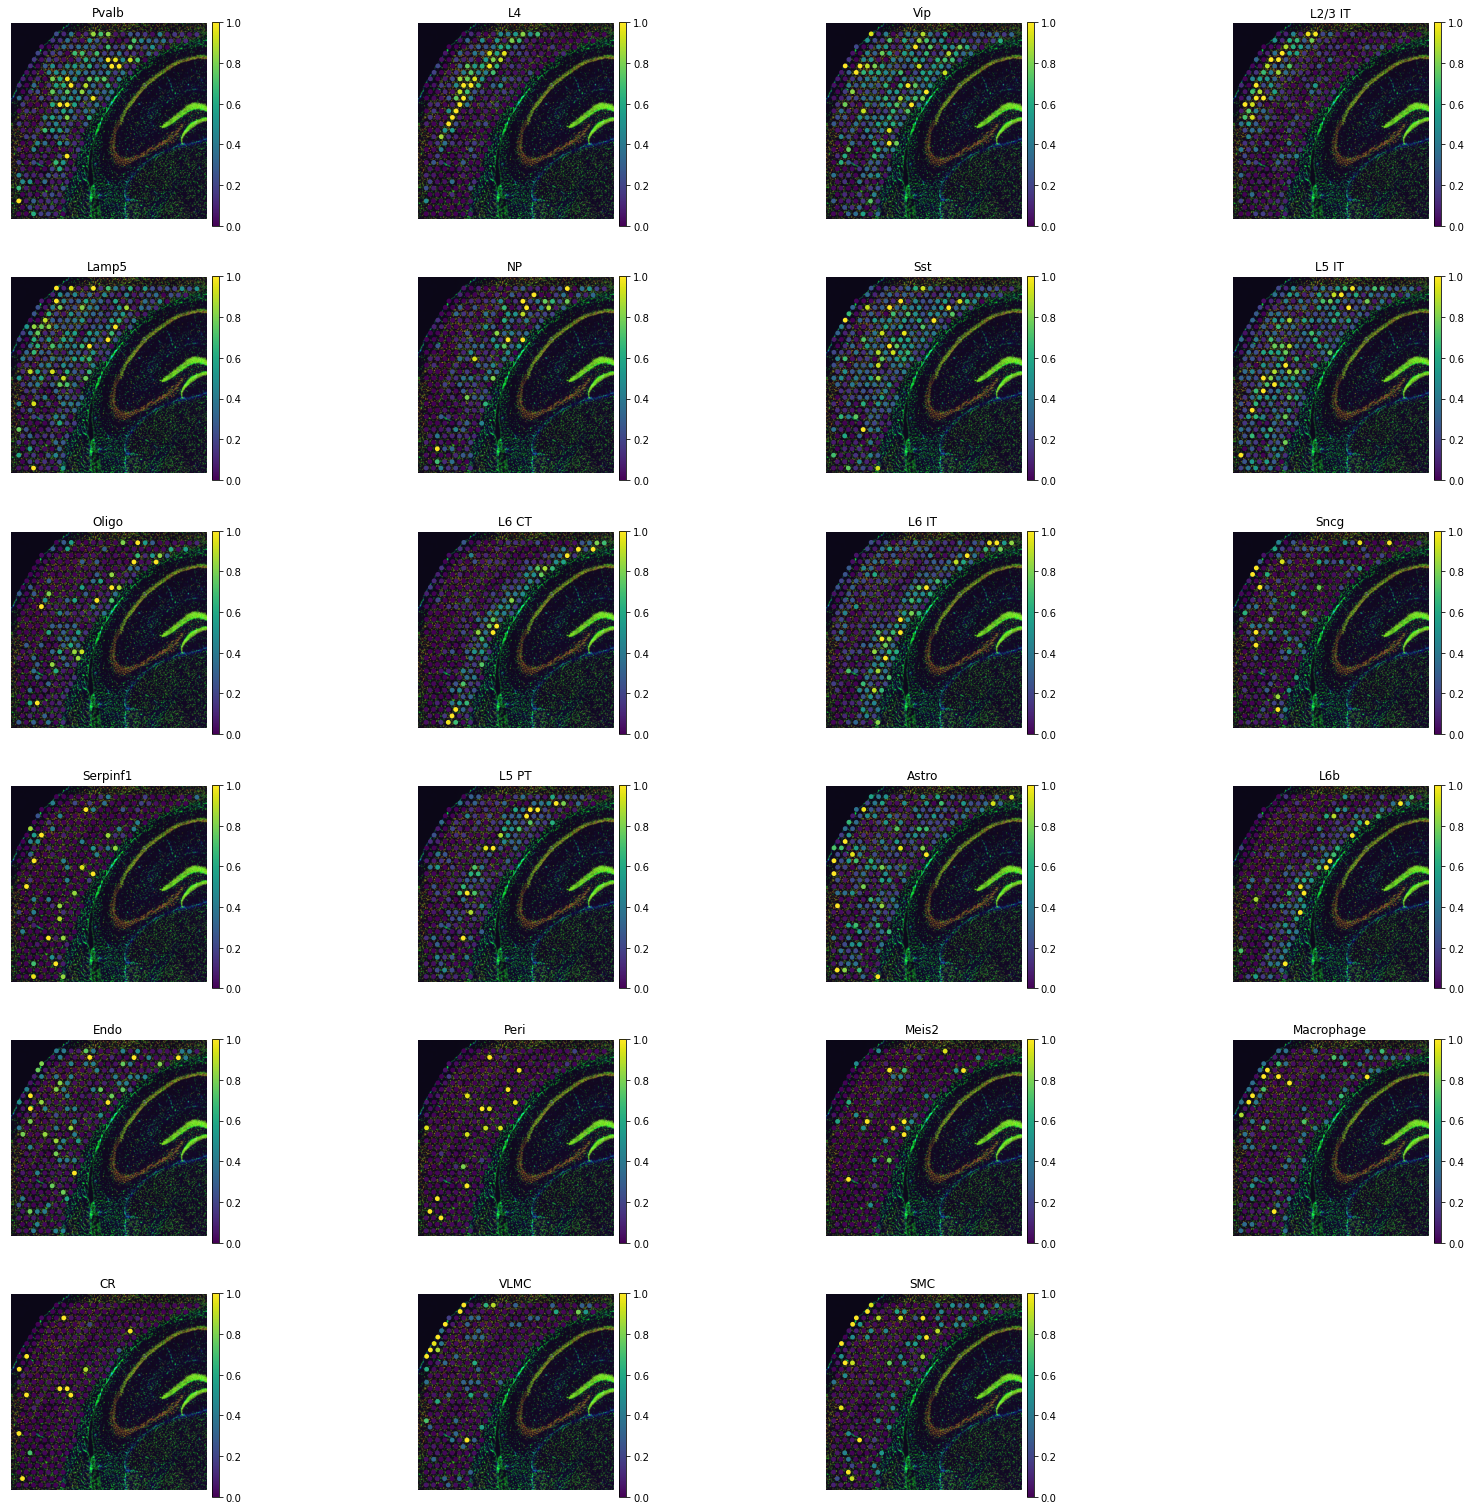

In [ ]:

annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg.plot_cell_annotation(adata_st, annotation_list, perc=0.02)

We validate mapping by inspecting the test transcriptome:

<Figure size 432x288 with 0 Axes>

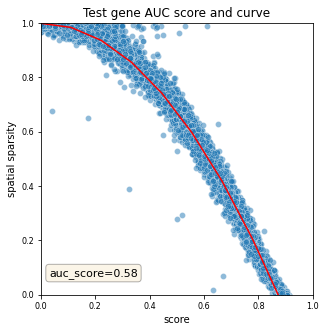

In [ ]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
tg.plot_auc(df_all_genes);

And here comes the key part, where we will use the results of the previous deconvolution steps. Previously, we computed the absolute numbers of unique segmentation objects under each spot, together with their centroids. Let's extract them in the right format useful for _Tangram_. In the resulting dataframe, each row represents a single segmentation object (a cell). We also have the image coordinates as well as the unique centroid ID, which is a string that contains both the spot ID and a numerical index. _Tangram_ provides a convenient function to export the mapping between spot ID and segmentation ID to `adata.uns`.

In [ ]:
tg.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"].head()

spot_idx            y           x             centroids
0  AAATGGCATGTCTTGT-1  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0
1  AAATGGCATGTCTTGT-1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1
2  AAATGGCATGTCTTGT-1  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2
3  AAATGGCATGTCTTGT-1  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3
4  AAATGGCATGTCTTGT-1  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4

We can use `tangram.count_cell_annotation()` to map cell types as result of the deconvolution step to putative segmentation ID.

In [ ]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
adata_st.obsm["tangram_ct_count"].head()

x     y  cell_n  \
AAATGGCATGTCTTGT-1   641  5393      13   
AACAACTGGTAGTTGC-1  4208  1672      16   
AACAGGAAATCGAATA-1  1117  5117      28   
AACCCAGAGACGGAGA-1  1101  1274       5   
AACCGTTGTGTTTGCT-1   399  4708       7   

                                                            centroids  Pvalb  \
AAATGGCATGTCTTGT-1  [AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...      1   
AACAACTGGTAGTTGC-1  [AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...      1   
AACAGGAAATCGAATA-1  [AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...      3   
AACCCAGAGACGGAGA-1  [AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...      1   
AACCGTTGTGTTTGCT-1  [AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...      1   

                    L4  Vip  L2/3 IT  Lamp5  NP  ...  L5 PT  Astro  L6b  Endo  \
AAATGGCATGTCTTGT-1   0    1        0      0   0  ...      1      1    0     0   
AACAACTGGTAGTTGC-1   0    5        1      1   1  ...      3      0    0     0   
AACAGGAAATCGAATA-1   0    1        0      2   0  ...      0      0    0     0   
AACCCAGAGACGGAGA-1   0    0        1      1   0  ...      0      1    0     0   
AACCGTTGTGTTTGCT-1   0    0        0      1   0  ...      1      0    0     0   

                    Peri  Meis2  Macrophage  CR  VLMC  SMC  
AAATGGCATGTCTTGT-1     0      0           1   0     0    0  
AACAACTGGTAGTTGC-1     0      0           0   0     0    0  
AACAGGAAATCGAATA-1     0      1           0   0     0    0  
AACCCAGAGACGGAGA-1     0      0           0   0     1    0  
AACCGTTGTGTTTGCT-1     0      0           0   0     0    0  

[5 rows x 27 columns]

And finally export the results in a new `AnnData` object.

In [ ]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)
adata_segment.obs.head()

y           x             centroids cluster
0  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0   Pvalb
1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1     Vip
2  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2   L5 IT
3  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3   L6 CT
4  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4   L6 CT

Note that the AnnData object does not contain counts, but only cell type annotations, as results of the Tangram mapping.  Nevertheless, it's convenient to create such AnnData object for visualization purposes. Below you can appreciate how each dot is now not a Visium spot anymore, but a single unique segmentation object, with the mapped cell type.

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

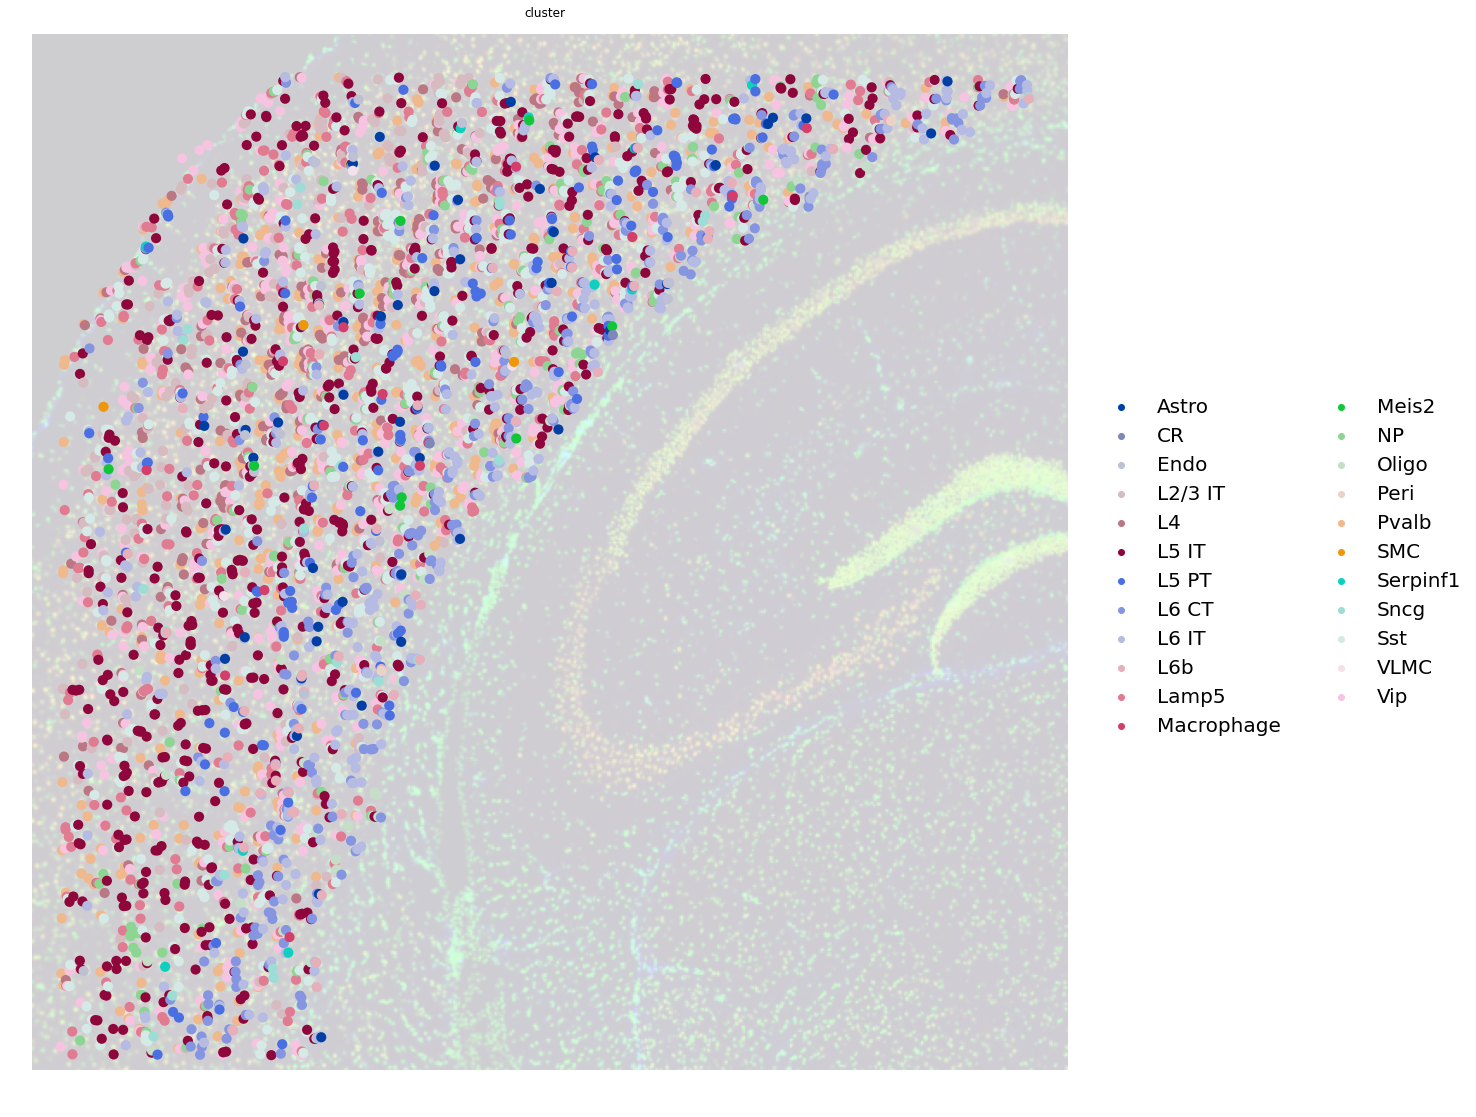

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)

### Simulation benchmark

In [17]:
from scipy.io import mmread
from starfysh import utils

#### (1). Major cell-type simulation (`simu_5`)

In [5]:
data_path = '../data/'
sample_id = 'simu_5'

# Synthetic spatial data
adata_st = sc.AnnData(pd.read_csv(os.path.join(data_path, sample_id, 'counts.st_synth.csv'), index_col=0))

In [36]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(data_path, sample_id, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(data_path, sample_id, 'proportions.st_synth.csv'),index_col=0)

In [37]:
# Create "pseudo" density prior by dividing library size to the avg. cell count 
cell_count = adata_st.X.sum(1) * (mem_df.sum(1).mean() / adata_st.X.sum(1).mean())
adata_st.obs['cell_count'] = cell_count

In [38]:
# Load paired scRNA-seq data
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'

barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)

In [39]:
major_dict = {
    'CAFs': 'CAFs',
    'Cancer Epithelial': 'Cancer_Epithelial',
    'Myeloid': 'Myeloid',
    'Normal Epithelial': 'Normal_Epithelial',
    'T-cells': 'T-cells'
}

In [40]:
# Rename annotations & only keep scRNA-seq index with cell types existing in the synthetic ST data
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_major'].apply(lambda x: major_dict[x] if x in major_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
adata_sc = adata_sc[cells_to_keep, :]
annots = annots[cells_to_keep]
adata_sc.obs['major_cell_types'] = annots[cells_to_keep].tolist()

adata_sc

AnnData object with n_obs × n_vars = 7261 × 29733
    obs: 'Barcode', 'major_cell_types'
    var: 'features'

Preprocessing:

In [41]:
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)


In [42]:
sc.tl.rank_genes_groups(adata_sc, groupby="major_cell_types", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

464

In [43]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

[2023-06-19 15:30:47] 443 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
[2023-06-19 15:30:47] 20483 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
[2023-06-19 15:30:47] uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
[2023-06-19 15:30:47] rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Deconvolution via alignment:

In [44]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cuda:0"
)



[2023-06-19 15:30:47] Allocate tensors for mapping.
[2023-06-19 15:30:47] Begin training with 443 genes and customized density_prior in constrained mode...


Score: 0.872, KL reg: 0.121, Count reg: 25198.615, Lambda f reg: 1501.979
Score: 0.958, KL reg: 0.010, Count reg: 21597.666, Lambda f reg: 48.323
Score: 0.964, KL reg: 0.010, Count reg: 21568.238, Lambda f reg: 19.185
Score: 0.966, KL reg: 0.010, Count reg: 21559.846, Lambda f reg: 10.829
Score: 0.966, KL reg: 0.010, Count reg: 21556.123, Lambda f reg: 7.115
Score: 0.967, KL reg: 0.009, Count reg: 21554.100, Lambda f reg: 5.096
Score: 0.967, KL reg: 0.009, Count reg: 21552.861, Lambda f reg: 3.858
Score: 0.967, KL reg: 0.009, Count reg: 21552.039, Lambda f reg: 3.037
Score: 0.967, KL reg: 0.009, Count reg: 21551.461, Lambda f reg: 2.460
Score: 0.967, KL reg: 0.009, Count reg: 21551.039, Lambda f reg: 2.037


[2023-06-19 15:31:09] Saving results..


Parse & save deconvolution results:

In [46]:
# Appending spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata_st.obs.index,
                                    hchannel=False)

img, map_info, scalefactor = img_metadata['img'], img_metadata['map_info'], img_metadata['scalefactor']
map_info = map_info[['array_row', 'array_col']].astype(float)

In [51]:
adata_st.uns['spatial'] = {
    sample_id: {
        'images': {'hires': (img - img.min()) / (img.max() - img.min())},
        'scalefactors': scalefactor
    },
}

adata_st.obsm['spatial'] = map_info[['array_col', 'array_row']].values


In [53]:
tg.project_cell_annotations(ad_map, adata_st, annotation="major_cell_types")

[2023-06-19 15:35:39] spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [64]:
cell_types = np.unique(adata_sc.obs['major_cell_types'])
adata_st.obsm['tangram_ct_pred'] = adata_st.obsm['tangram_ct_pred'].div(adata_st.obsm['tangram_ct_pred'].sum(1), 0)
adata_st.obsm['tangram_ct_pred'] = adata_st.obsm['tangram_ct_pred'][cell_types]
adata_st.obsm['tangram_ct_pred'].head()

CAFs  Cancer_Epithelial   Myeloid  Normal_Epithelial   T-cells
location_0  0.148725           0.000186  0.000080           0.000261  0.850748
location_1  0.184908           0.000273  0.000097           0.036876  0.777846
location_2  0.169711           0.007097  0.046771           0.045471  0.730951
location_3  0.247414           0.049154  0.185469           0.063651  0.454312
location_4  0.192884           0.034498  0.223777           0.070712  0.478129

In [65]:
adata_st.obsm['tangram_ct_pred'].to_csv('results/Tangarm_proportion_simu_5.csv', index=True)

#### (2). Fine-grained cell-type simulation (`simu_10`)

In [66]:
data_path = '../data/'
sample_id = 'simu_10'

# Synthetic spatial data
adata_st = sc.AnnData(pd.read_csv(os.path.join(data_path, sample_id, 'counts.st_synth.csv'), index_col=0))

In [67]:
# Load ground-truth proportion & densities
mem_df = pd.read_csv(os.path.join(data_path, sample_id, 'members.st_synth.csv'),index_col=0)
prop_df = pd.read_csv(os.path.join(data_path, sample_id, 'proportions.st_synth.csv'),index_col=0)

In [68]:
# Create "pseudo" density prior by dividing library size to the avg. cell count 
cell_count = adata_st.X.sum(1) * (mem_df.sum(1).mean() / adata_st.X.sum(1).mean())
adata_st.obs['cell_count'] = cell_count

In [69]:
# Get subset-level annotations from available cell types in ground-truth
subset_dict = {
    'Cancer Basal SC':                  'Basal',
    'Cancer LumB SC':                   'LumB',
    'Myoepithelial':                    'Normal epithelial',
    'T_cells_c0_CD4+_CCR7':             'Tcm',
    'T_cells_c1_CD4+_IL7R':             'Tem',
    'T_cells_c3_CD4+_Tfh_CXCL13':       'Tfh',
    'T_cells_c2_CD4+_T-regs_FOXP3':     'Treg',
    'T_cells_c7_CD8+_IFNG':             'Activated CD8',
    'T_cells_c8_CD8+_LAG3':             'Terminal exhaustion',
    'B cells Memory':                   'B cells memory',
    'B cells Naive':                    'B cells naive',
    'Myeloid_c10_Macrophage_1_EGR1':    'Macrophage M1',
    'Myeloid_c9_Macrophage_2_CXCL10':   'Macrophage M2',
    'Plasmablasts':                     'Plasmablasts',
    'Myeloid_c7_Monocyte_3_FCGR3A':     'Monocytes',
    'Myeloid_c12_Monocyte_1_IL1B':      'Monocytes',
    'Myeloid_c8_Monocyte_2_S100A9':     'Monocytes',
    'Myeloid_c11_cDC2_CD1C':            'cDC',
    'Myeloid_c3_cDC1_CLEC9A':           'cDC',
    'Myeloid_c4_DCs_pDC_IRF7':          'pDC',
    'CAFs MSC iCAF-like s1':            'CAFs MSC iCAF-like',
    'CAFs MSC iCAF-like s2':            'CAFs MSC iCAF-like',
    'CAFs myCAF like s4':               'CAFs myCAF-like',
    'CAFs myCAF like s5':               'CAFs myCAF-like',
    'PVL Immature s1':                  'PVL immature',
    'PVL_Immature s2':                  'PVL immature',
    'PVL Differentiated s3':            'PVL differentiated',
    'Endothelial ACKR1':                'Endothelial',
    'Endothelial CXCL12':               'Endothelial',
    'Endothelial Lymphatic LYVE1':      'Endothelial',
    'Endothelial RGS5':                 'Endothelial'
}

In [70]:
# Load paired scRNA-seq data
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'

barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)

In [4]:
# DEBUG: check annotation labels
sc_path = '../../starfysh/data/CID44971_TNBC/scrna/'
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_subset']

In [5]:
annots

CID44971_AAGCCGCCACGCATCG    Endothelial ACKR1
CID44971_AAGGAGCTCAACACAC    Endothelial ACKR1
CID44971_ACGAGCCTCCGATATG    Endothelial ACKR1
CID44971_ACGTCAATCCGAAGAG    Endothelial ACKR1
CID44971_AGAGTGGCACACGCTG    Endothelial ACKR1
                                   ...        
CID44971_TTGACTTTCTCTTATG       Mature Luminal
CID44971_TTGGCAAGTTCGTCTC       Mature Luminal
CID44971_TTTATGCTCAGATAAG       Mature Luminal
CID44971_TTTCCTCCAAGCCATT       Mature Luminal
CID44971_TTTGGTTGTATCACCA       Mature Luminal
Name: celltype_subset, Length: 7986, dtype: object

In [71]:
# Rename annotations & only keep scRNA-seq index with 10 cell types existing in the synthetic ST data
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
annots = meta_df['celltype_subset'].apply(lambda x: subset_dict[x] if x in subset_dict.keys() else np.nan)

cells_to_keep = annots.isin(prop_df.columns)
adata_sc = adata_sc[cells_to_keep, :]
annots = annots[cells_to_keep]
adata_sc.obs['subset_cell_types'] = annots[cells_to_keep].tolist()

adata_sc

AnnData object with n_obs × n_vars = 3901 × 29733
    obs: 'Barcode', 'subset_cell_types'
    var: 'features'

Preprocessing:

In [72]:
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)


In [73]:
sc.tl.rank_genes_groups(adata_sc, groupby="subset_cell_types", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

699

In [74]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

[2023-06-19 15:42:12] 699 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
[2023-06-19 15:42:12] 18148 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
[2023-06-19 15:42:12] uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
[2023-06-19 15:42:12] rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Deconvolution via alignment:

In [75]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cuda:0"
)



[2023-06-19 15:42:34] Allocate tensors for mapping.
[2023-06-19 15:42:34] Begin training with 699 genes and customized density_prior in constrained mode...


Score: 0.608, KL reg: 0.337, Count reg: 23581.484, Lambda f reg: 804.656
Score: 0.818, KL reg: 0.028, Count reg: 21648.107, Lambda f reg: 25.924
Score: 0.825, KL reg: 0.026, Count reg: 21632.320, Lambda f reg: 10.292
Score: 0.826, KL reg: 0.026, Count reg: 21627.818, Lambda f reg: 5.809
Score: 0.827, KL reg: 0.026, Count reg: 21625.820, Lambda f reg: 3.817
Score: 0.827, KL reg: 0.026, Count reg: 21624.736, Lambda f reg: 2.734
Score: 0.828, KL reg: 0.026, Count reg: 21624.070, Lambda f reg: 2.070
Score: 0.828, KL reg: 0.026, Count reg: 21623.631, Lambda f reg: 1.629
Score: 0.828, KL reg: 0.026, Count reg: 21623.320, Lambda f reg: 1.320
Score: 0.828, KL reg: 0.026, Count reg: 21623.094, Lambda f reg: 1.093


[2023-06-19 15:42:49] Saving results..


Parse & save deconvolution results:

In [77]:
tg.project_cell_annotations(ad_map, adata_st, annotation="subset_cell_types")

[2023-06-19 15:43:13] spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [78]:
cell_types = np.unique(adata_sc.obs['subset_cell_types'])
adata_st.obsm['tangram_ct_pred'] = adata_st.obsm['tangram_ct_pred'].div(adata_st.obsm['tangram_ct_pred'].sum(1), 0)
adata_st.obsm['tangram_ct_pred'] = adata_st.obsm['tangram_ct_pred'][cell_types]
adata_st.obsm['tangram_ct_pred'].head()

Activated CD8  B cells memory     Basal  \
exper0_location_0       0.000079        0.000105  0.000097   
exper0_location_1       0.000060        0.000070  0.028195   
exper0_location_2       0.000061        0.000055  0.000086   
exper0_location_3       0.000074        0.000047  0.222787   
exper0_location_4       0.005633        0.006369  0.222476   

                   CAFs MSC iCAF-like  CAFs myCAF-like  Endothelial  \
exper0_location_0            0.990179         0.009112     0.000061   
exper0_location_1            0.406689         0.014302     0.000070   
exper0_location_2            0.997210         0.002249     0.000054   
exper0_location_3            0.553536         0.052218     0.000046   
exper0_location_4            0.239056         0.007524     0.000070   

                   PVL immature       Tcm      Treg       pDC  
exper0_location_0      0.000007  0.000203  0.000151  0.000005  
exper0_location_1      0.000006  0.018870  0.531737  0.000002  
exper0_location_2      0.000009  0.000166  0.000103  0.000008  
exper0_location_3      0.000006  0.000203  0.171079  0.000004  
exper0_location_4      0.000005  0.303698  0.215166  0.000002

In [80]:
adata_st.obsm['tangram_ct_pred'].to_csv('results/Tangarm_proportion_simu_10.csv', index=True)